In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import eigh
from scipy.stats import norm, beta
# Given data
y = np.array(pd.read_csv('project/data_y.csv'))
z = np.array(pd.read_csv('project/data_z.csv'))

# Check if a value is numeric (float or integer)
def is_numeric(val):
    return isinstance(val, (int, float))

# Apply the check to each element in the array and create a boolean mask
numeric_mask_y = np.vectorize(is_numeric)(y)
numeric_mask_z = np.vectorize(is_numeric)(z)


# Use the boolean mask to filter out non-numeric values
y = y[numeric_mask_y]
z = z[numeric_mask_z]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


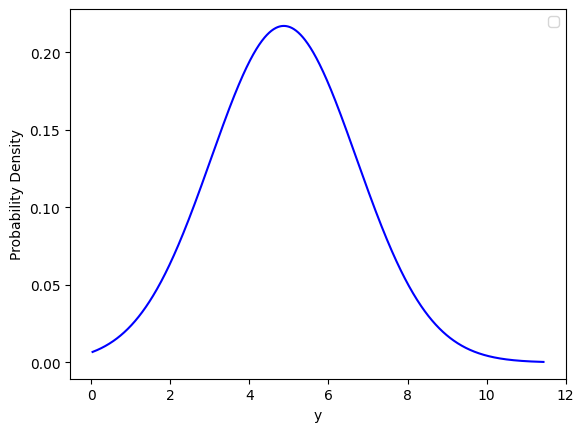

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


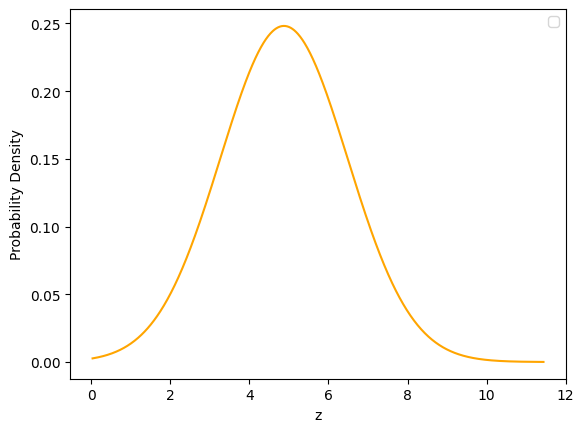

In [2]:
# Calculate mean and standard deviation for y and z
mean_y, std_y = np.mean(y), np.std(y)
mean_z, std_z = np.mean(z), np.std(z)

# Create a range of values for x-axis
x = np.linspace(min(min(y), min(z)), max(max(y), max(z)), 1000)

# Calculate the Gaussian PDF for y and z
pdf_y = norm.pdf(x, mean_y, std_y)
pdf_z = norm.pdf(x, mean_z, std_z)

# Plot the PDFs

plt.plot(x, pdf_y, color='blue')
plt.legend(loc='upper right')
plt.xlabel('y')
plt.ylabel('Probability Density')
plt.show()
plt.plot(x, pdf_z, color='orange')
plt.legend(loc='upper right')
plt.xlabel('z')
plt.ylabel('Probability Density')
#plt.title('PDF of Gaussian Distributions for y and z')
plt.show()

In [3]:
# Discretize the domain
num_intervals = 60
interval_size = int(y.shape[0] / num_intervals)

# Parameters for the Gaussian covariance function
sigma_sq = 4  # Variance
lambda_ = 20  # Correlation length

# Define the Gaussian covariance function
def covariance_function(x1, x2):
    h = abs(x1 - x2)
    return sigma_sq * np.exp(-(h**2) / (2 * lambda_**2))

# Calculate the covariance matrix
cov_matrix = np.zeros((num_intervals, num_intervals))
for i in range(num_intervals):
    for j in range(num_intervals):
        cov_matrix[i, j] = covariance_function(i * interval_size, j * interval_size)

# Perform eigen decomposition
eigenvalues, eigenvectors = eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

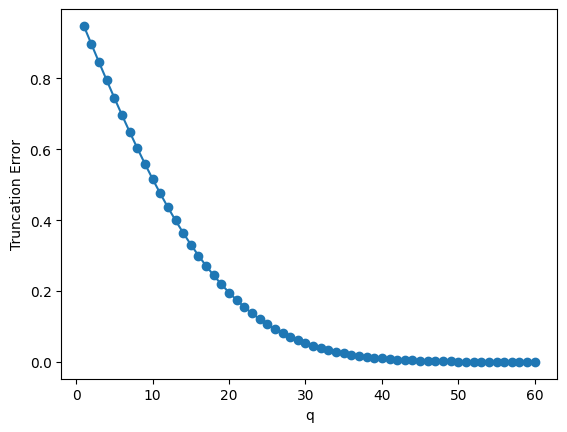

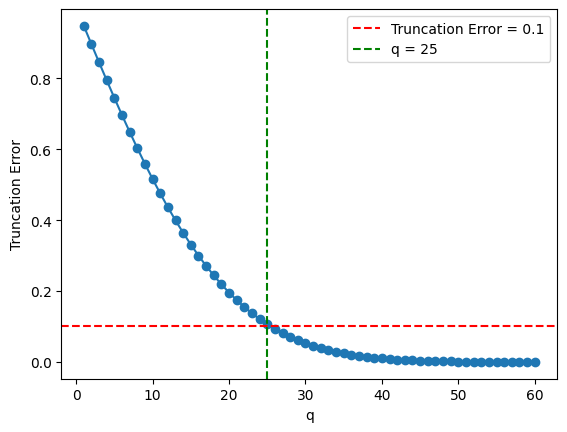

q value when truncation error is 0.1: 25


In [4]:
# Calculate the truncation error for different q values
truncation_errors = []
trace_cov_matrix = np.trace(cov_matrix)

for q in range(1, num_intervals + 1):
    truncation_error = 1 - (np.sum(eigenvalues[:q]) / trace_cov_matrix)
    truncation_errors.append(truncation_error)

# Plot the truncation error for different q values
plt.plot(range(1, num_intervals + 1), truncation_errors, marker='o')
plt.xlabel('q')
plt.ylabel('Truncation Error')
#plt.title('Truncation Error for Different q Values')
plt.show()

# Find the q value when truncation error is 0.1
threshold = 0.1
q_value = np.argwhere(np.array(truncation_errors) <= threshold)[0][0] 

# Plot the truncation error for different q values
plt.plot(range(1, num_intervals + 1), truncation_errors, marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Truncation Error = {threshold}')
plt.axvline(x=q_value, color='g', linestyle='--', label=f'q = {q_value}')
plt.xlabel('q')
plt.ylabel('Truncation Error')
#plt.title('Truncation Error for Different q Values')
plt.legend()
plt.show()

print(f"q value when truncation error is {threshold}: {q_value}")

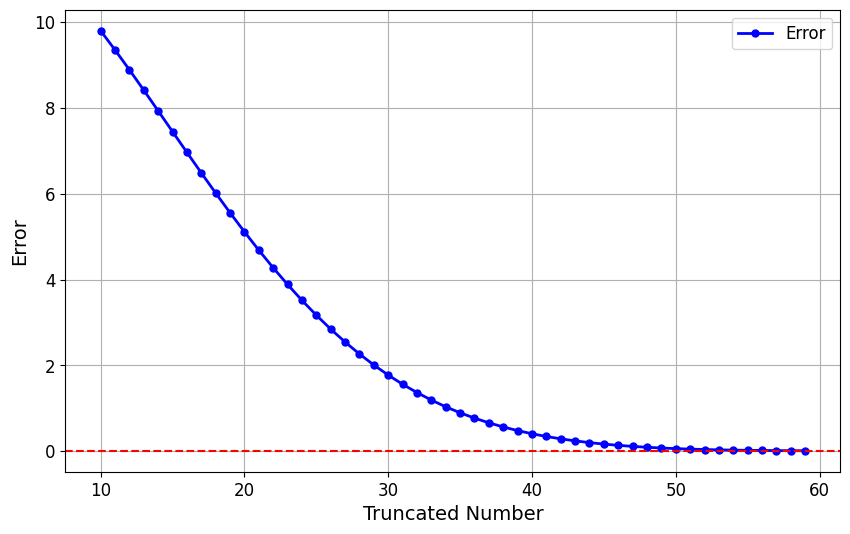

m value when error converges: 50


In [5]:
# Calculate the covariance matrix difference error for different truncation degrees
errors = []

for m in range(10, num_intervals ):
    truncated_eigenvalues = np.copy(eigenvalues)
    truncated_eigenvalues[m:] = 0
    truncated_cov_matrix = eigenvectors @ np.diag(truncated_eigenvalues) @ eigenvectors.T
    error = np.linalg.norm(truncated_cov_matrix - cov_matrix, ord=2)
    errors.append(error)

min_error_index = np.argmin(errors)
min_error = errors[min_error_index]
converging_m = min_error_index + 1

# Plot the error for different truncation degrees
plt.figure(figsize=(10, 6))
plt.plot(range(10, num_intervals ), errors, marker='o', markersize=5, linestyle='-', linewidth=2, color='blue', label='Error')
plt.axhline(y=0, color='r', linestyle='--')
#plt.axvline(x=converging_m, color='g', linestyle='--', label=f'm = {converging_m}')
plt.xlabel('Truncated Number', fontsize=14)
plt.ylabel('Error', fontsize=14)
#plt.title('Error for Different Truncation Degrees', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print(f"m value when error converges: {converging_m}")

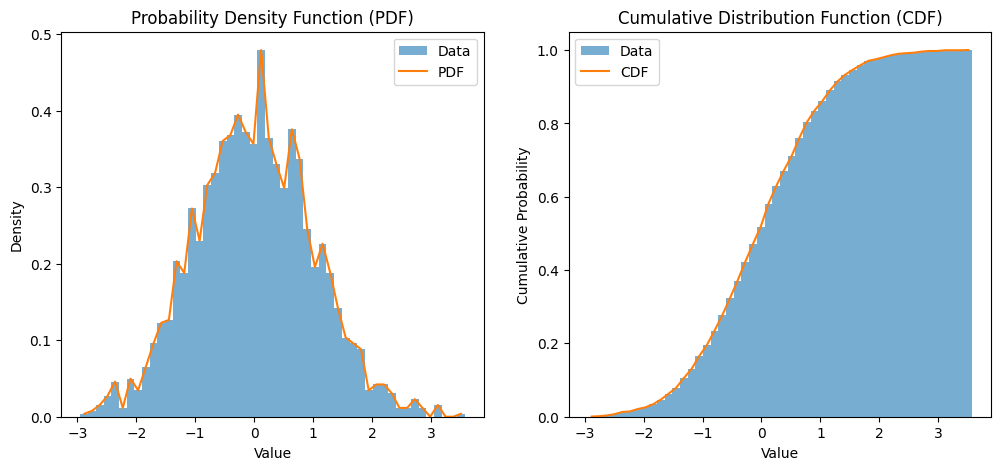

In [6]:
from scipy.stats import norm, beta

# Transform the distributions of inputs using the Maximum Entropy principle
def max_entropy_transform(data):
    return (data - data.mean(axis=0)) / data.std(axis=0)

non_gaussian_y = max_entropy_transform(y)
non_gaussian_z = max_entropy_transform(z)

# Combine the transformed data into a single array
combined_data = np.concatenate([non_gaussian_y, non_gaussian_z], axis=0)

# Plot the PDF and CDF of the transformed data
x_values = np.linspace(combined_data.min(), combined_data.max(), 1000)
pdf_values, bin_edges = np.histogram(combined_data, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cdf_values = np.cumsum(pdf_values) / np.sum(pdf_values)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(combined_data, bins=50, density=True, alpha=0.6, label='Data')
plt.plot(bin_centers, pdf_values, label='PDF')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Probability Density Function (PDF)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(combined_data, bins=50, density=True, alpha=0.6, cumulative=True, label='Data')
plt.plot(bin_centers, cdf_values, label='CDF')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF)')
plt.legend()

plt.show()

In [7]:
# Fit the data to a Beta distribution
a, b, loc, scale = beta.fit(combined_data, floc=-4, fscale=10)
print(f"Fitted Beta distribution parameters: a={a:.4f}, b={b:.4f}, loc={loc:.4f}, scale={scale:.4f}")

Fitted Beta distribution parameters: a=9.0944, b=13.6496, loc=-4.0000, scale=10.0000


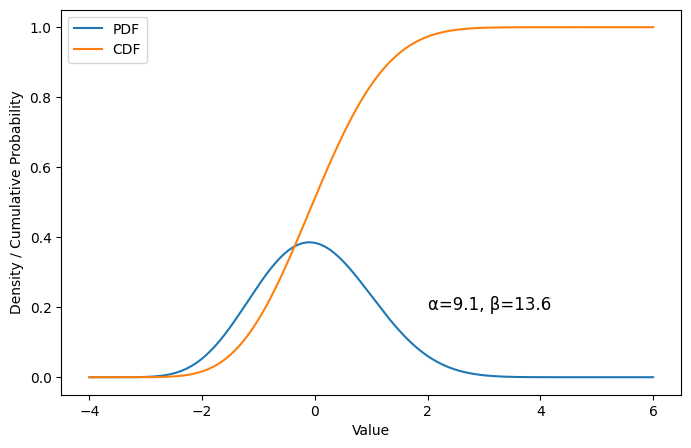

In [8]:
a, b, loc, scale = 9.0944, 13.6496, -4.0000, 10.0000

x_values = np.linspace(loc, loc + scale, 1000)
pdf_values = beta.pdf(x_values, a, b, loc=loc, scale=scale)
cdf_values = beta.cdf(x_values, a, b, loc=loc, scale=scale)

plt.figure(figsize=(8, 5))

plt.plot(x_values, pdf_values, label='PDF')
plt.plot(x_values, cdf_values, label='CDF')

plt.xlabel('Value')
plt.ylabel('Density / Cumulative Probability')
#plt.title('PDF and CDF of Fitted Beta Distribution')
plt.legend()
# Add the text with alpha and beta values
plt.text(loc + scale * 0.6, max(pdf_values) * 0.5, f'α={a:.1f}, β={b:.1f}', fontsize=12)


plt.show()


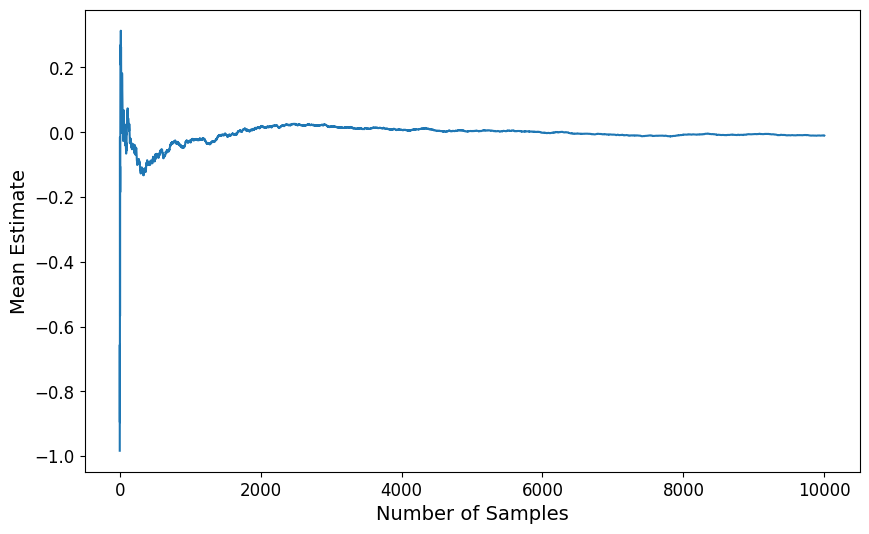

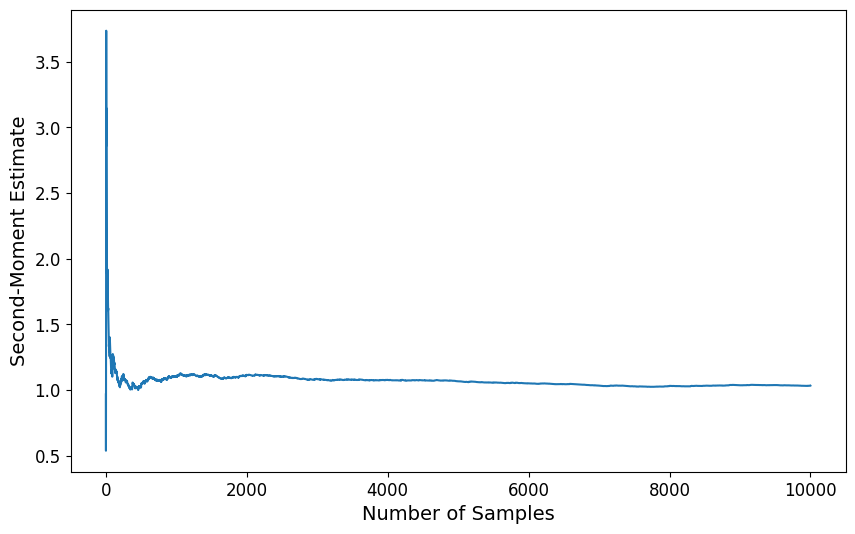

In [9]:
# Monte Carlo simulation using Beta distribution
num_samples = 10000
a, b, loc, scale = 8.8245, 13.2697, -4.0000, 10.0000
samples = np.random.beta(a, b, (num_samples, num_intervals)) * scale + loc

# Calculate the mean and second-moment estimates
mean_estimates = np.cumsum(samples, axis=0) / np.arange(1, num_samples + 1)[:, np.newaxis]
second_moment_estimates = np.cumsum(samples**2, axis=0) / np.arange(1, num_samples + 1)[:, np.newaxis]

# Extract end node data
end_node_samples = samples[:, -1]
end_node_mean_estimates = mean_estimates[:, -1]
end_node_second_moment_estimates = second_moment_estimates[:, -1]

# Plot the mean convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_samples + 1), end_node_mean_estimates)
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel('Mean Estimate', fontsize=14)
#plt.title('Convergence of Mean', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plot the second-moment convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_samples + 1), end_node_second_moment_estimates)
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel('Second-Moment Estimate', fontsize=14)
#plt.title('Convergence of Second-Moment', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

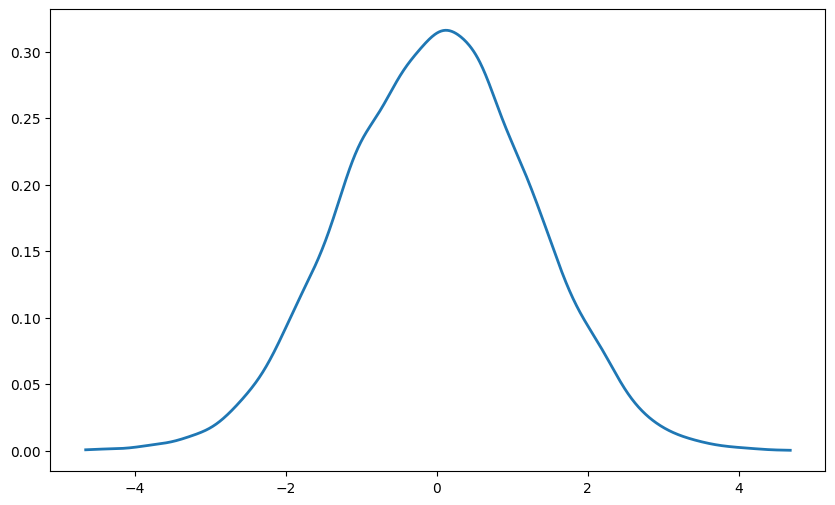

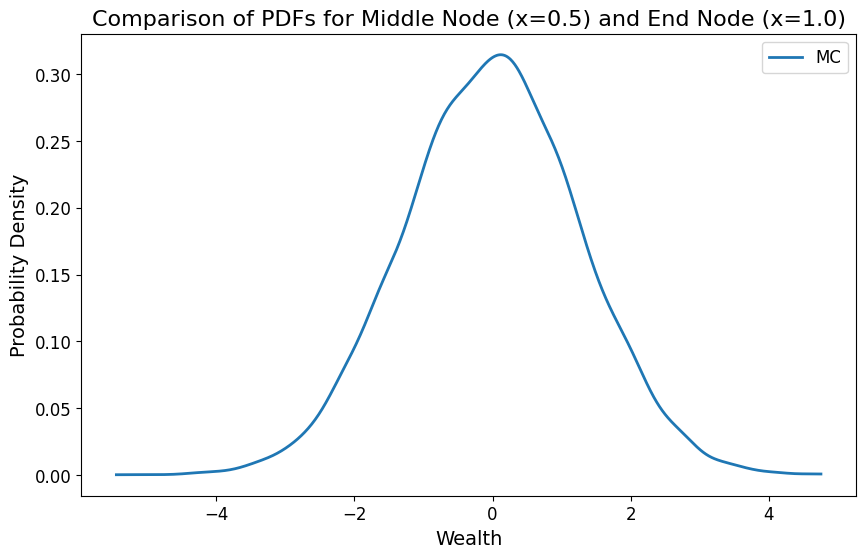

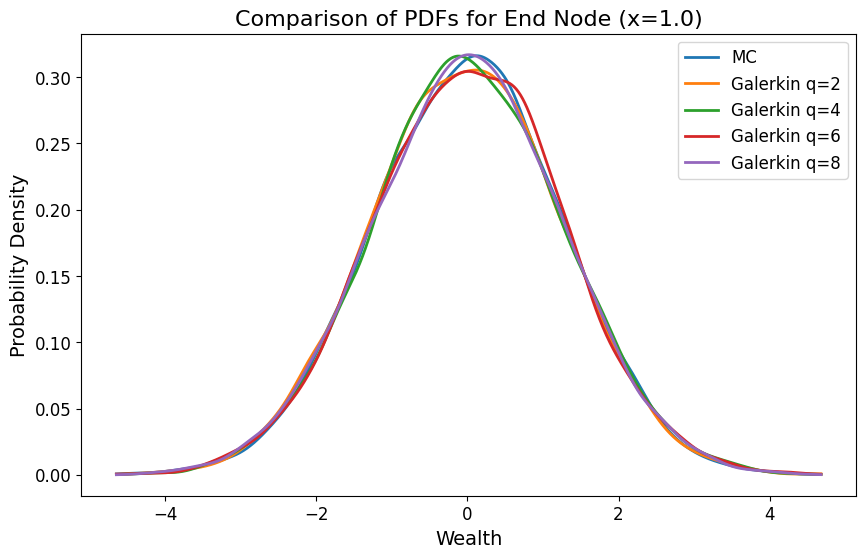

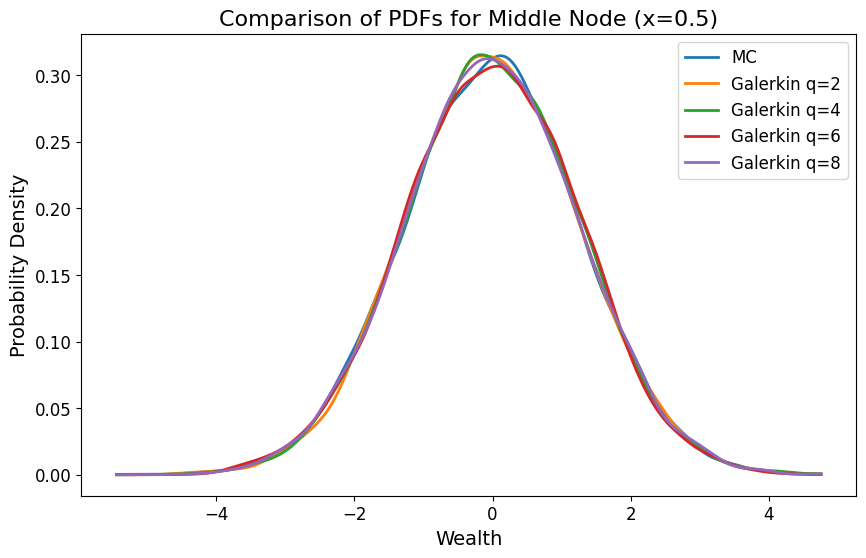

In [10]:
from scipy.stats import gaussian_kde

# Calculate wealth for each sample
ω_i = np.mean(y, axis=0)  # Element averages of nodal values for y
μ_i = np.mean(z, axis=0)  # Element averages of nodal values for z
wealth = np.zeros((num_samples, num_intervals))

for m in range(num_samples):
    η = np.random.normal(size=(num_intervals, num_intervals))
    wealth[m] = (ω_i * η + μ_i * η).sum(axis=1) / num_intervals

# Extract wealth for end node and middle node
end_node_wealth = wealth[:, -1]
middle_node_wealth = wealth[:, num_intervals // 2]

# Plot the PDFs for end node (x=1.0)
plt.figure(figsize=(10, 6))

mc_kde_end_node = gaussian_kde(end_node_wealth)
x_values_end_node = np.linspace(min(end_node_wealth), max(end_node_wealth), 1000)
plt.plot(x_values_end_node, mc_kde_end_node(x_values_end_node), label='MC', linewidth=2)

# Plot the PDFs for middle node (x=0.5)
plt.figure(figsize=(10, 6))

mc_kde_middle_node = gaussian_kde(middle_node_wealth)
x_values_middle_node = np.linspace(min(middle_node_wealth), max(middle_node_wealth), 1000)
plt.plot(x_values_middle_node, mc_kde_middle_node(x_values_middle_node), label='MC', linewidth=2)

plt.xlabel('Wealth', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison of PDFs for Middle Node (x=0.5) and End Node (x=1.0)', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Galerkin method with different polynomial degrees
q_values = [2, 4, 6, 8]
galerkin_wealth_end_node = {}
galerkin_wealth_middle_node = {}

for q in q_values:
    truncated_eigenvectors = eigenvectors[:, :q]
    galerkin_sample = np.random.normal(size=(num_samples, q)) @ np.diag(np.sqrt(eigenvalues[:q])) @ truncated_eigenvectors.T

    # Calculate wealth for each Galerkin sample
    wealth_galerkin = np.zeros((num_samples, num_intervals))
    for m in range(num_samples):
        η_galerkin = np.random.normal(size=(num_intervals, num_intervals))
        wealth_galerkin[m] = (ω_i * η_galerkin + μ_i * η_galerkin).sum(axis=1) / num_intervals

    galerkin_wealth_end_node[q] = wealth_galerkin[:, -1]
    galerkin_wealth_middle_node[q] = wealth_galerkin[:, num_intervals // 2]

# Plot the PDFs for end node (x=1.0)
plt.figure(figsize=(10, 6))

mc_kde_end_node = gaussian_kde(end_node_wealth)
x_values_end_node = np.linspace(min(end_node_wealth), max(end_node_wealth), 1000)
plt.plot(x_values_end_node, mc_kde_end_node(x_values_end_node), label='MC', linewidth=2)

for q in q_values:
    galerkin_kde_end_node = gaussian_kde(galerkin_wealth_end_node[q])
    plt.plot(x_values_end_node, galerkin_kde_end_node(x_values_end_node), label=f'Galerkin q={q}', linewidth=2)

plt.xlabel('Wealth', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison of PDFs for End Node (x=1.0)', fontsize=16)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plot the PDFs for middle node (x=0.5)
plt.figure(figsize=(10, 6))

mc_kde_middle_node = gaussian_kde(middle_node_wealth)
x_values_middle_node = np.linspace(min(middle_node_wealth), max(middle_node_wealth), 1000)
plt.plot(x_values_middle_node, mc_kde_middle_node(x_values_middle_node), label='MC', linewidth=2)

for q in q_values:
    galerkin_kde_middle_node = gaussian_kde(galerkin_wealth_middle_node[q])
    plt.plot(x_values_middle_node, galerkin_kde_middle_node(x_values_middle_node), label=f'Galerkin q={q}', linewidth=2)

plt.xlabel('Wealth', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison of PDFs for Middle Node (x=0.5)', fontsize=16)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


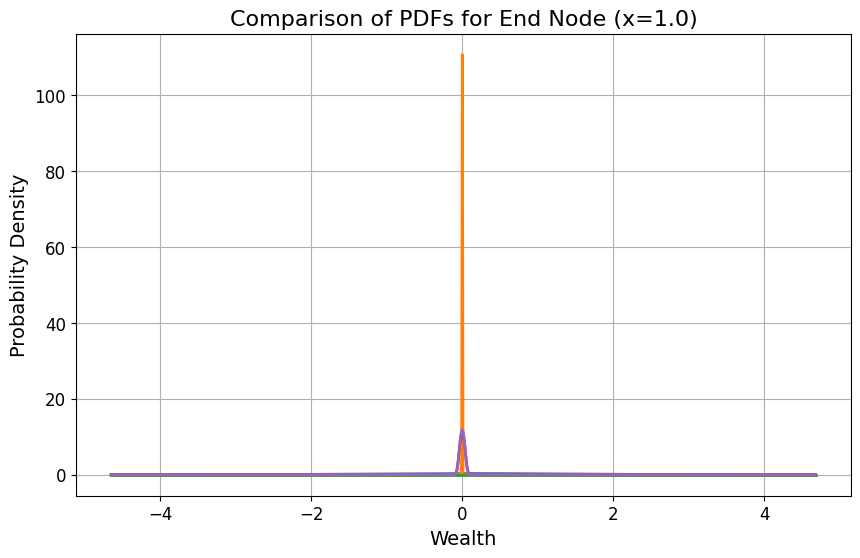

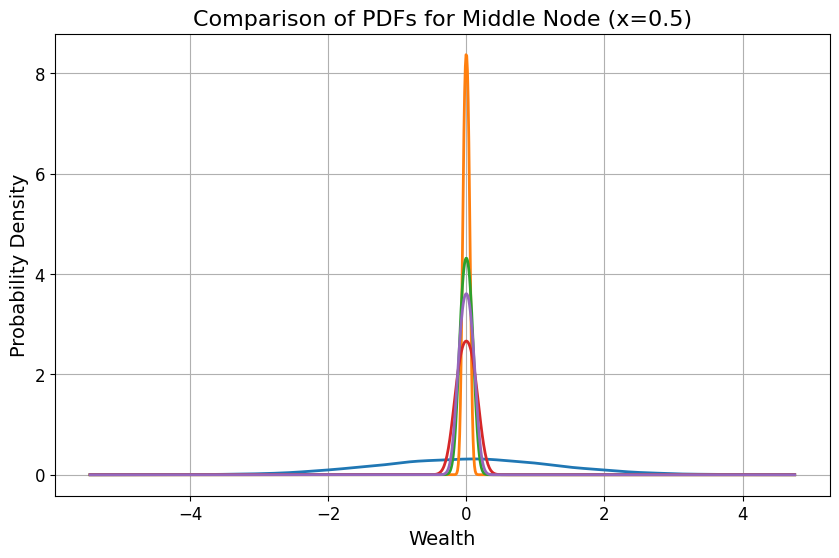

In [11]:
import chaospy as cp

# Stochastic Collocation with Gaussian-Hermite quadrature and Smolyak sparse grid
q_values = [2, 4, 6, 8]
collocation_wealth_end_node = {}
collocation_wealth_middle_node = {}

for q in q_values:
    distribution = cp.Normal(0, 1)
    poly_order = 1  # Second-order quadrature
    rule = 'G'  # Gaussian-Hermite quadrature
    samples, weights = cp.generate_quadrature(poly_order, distribution, rule=rule, sparse=True)  # Smolyak sparse grid

    # Calculate wealth for each Stochastic Collocation sample
    wealth_collocation = np.zeros((len(samples[0]), num_intervals))
    for m, sample in enumerate(samples.T):
        truncated_eigenvectors = eigenvectors[:, :q]
        η_collocation = truncated_eigenvectors * sample[:, None]
        wealth_collocation[m] = (ω_i * η_collocation + μ_i * η_collocation).sum(axis=1) / num_intervals

    collocation_wealth_end_node[q] = wealth_collocation[:, -1]
    collocation_wealth_middle_node[q] = wealth_collocation[:, num_intervals // 2]

    
# Plot the PDFs for end node (x=1.0)
plt.figure(figsize=(10, 6))

mc_kde_end_node = gaussian_kde(end_node_wealth)
x_values_end_node = np.linspace(min(end_node_wealth), max(end_node_wealth), 1000)
plt.plot(x_values_end_node, mc_kde_end_node(x_values_end_node), label='MC', linewidth=2)

for q in q_values:
    collocation_kde_end_node = gaussian_kde(collocation_wealth_end_node[q])
    plt.plot(x_values_end_node, collocation_kde_end_node(x_values_end_node), label=f'Stochastic Collocation q={q}', linewidth=2)

plt.xlabel('Wealth', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison of PDFs for End Node (x=1.0)', fontsize=16)
#plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plot the PDFs for middle node (x=0.5)
plt.figure(figsize=(10, 6))

mc_kde_middle_node = gaussian_kde(middle_node_wealth)
x_values_middle_node = np.linspace(min(middle_node_wealth), max(middle_node_wealth), 1000)
plt.plot(x_values_middle_node, mc_kde_middle_node(x_values_middle_node), label='MC', linewidth=2)

for q in q_values:
    collocation_kde_middle_node = gaussian_kde(collocation_wealth_middle_node[q])
    plt.plot(x_values_middle_node, collocation_kde_middle_node(x_values_middle_node), label=f'Stochastic Collocation q={q}', linewidth=2)

plt.xlabel('Wealth', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison of PDFs for Middle Node (x=0.5)', fontsize=16)
#plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


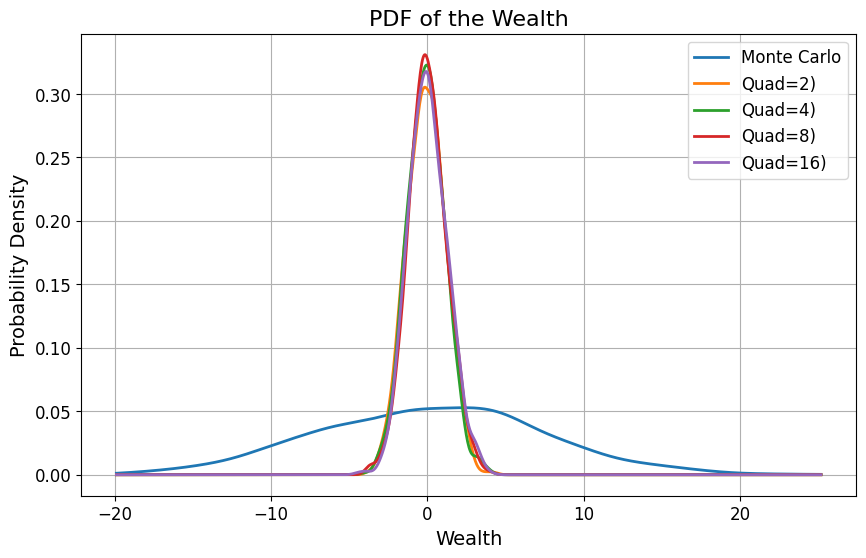

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm
from numpy.polynomial.laguerre import laggauss
from numpy.polynomial.hermite import hermgauss


# Discretize the domain
num_intervals = 100
interval_size = int(y.shape[0] / num_intervals)

# Monte Carlo simulation using standard normal distribution
num_samples = 1000
m = 50  # Number of random variables
samples = np.random.randn(num_samples, num_intervals, m)

# Calculate the wealth using Monte Carlo method
#ω_i = np.mean(y, axis=0)  # Element averages of nodal values for y
#μ_i = np.mean(z, axis=0)  # Element averages of nodal values for z
#wealth = np.zeros((num_samples, num_intervals))

#for m in range(num_samples):
#    η = np.random.normal(size=(num_intervals, num_intervals))
#    wealth[m] = (ω_i * η + μ_i * η).sum(axis=1) / num_intervals

# Extract wealth for end node and middle node
#mc_wealths = wealth[:, -1]

# Calculate the wealth using Monte Carlo method
wealths_mc = np.zeros(num_samples)
for i in range(num_samples):
    for j in range(num_intervals):
        eta = np.sum(samples[i, j])
        omega_i = np.mean(y[j * interval_size:(j + 1) * interval_size])
        mu_i = np.mean(z[j * interval_size:(j + 1) * interval_size])
        wealths_mc[i] += 1 / num_intervals * (omega_i * eta + mu_i * eta)

# Define the function to be integrated
def function_to_integrate(x, omega_i, mu_i):
    return norm.pdf(x) * (omega_i * x + mu_i * x)

# Calculate the wealth using Gauss-Hermite quadrature for different depths
quadrature_depths = [2, 4, 8, 16]
wealths_gl = {depth: np.zeros(num_samples) for depth in quadrature_depths}

for depth in quadrature_depths:
    x, w = laggauss(depth)
    for i in range(num_samples):
        for j in range(num_intervals):
            omega_i = np.mean(y[j * interval_size:(j + 1) * interval_size])
            mu_i = np.mean(z[j * interval_size:(j + 1) * interval_size])
            eta = np.random.randn(m)
            integral_sum = 0
            for k in range(depth):
                integrand = function_to_integrate(eta, omega_i, mu_i)
                integral_sum += np.sum(integrand * w[k])
            wealths_gl[depth][i] += 1 / num_intervals * integral_sum

# ... (the rest of the code remains unchanged)   
#Estimate the probability density function using kernel density estimation
kde_mc = gaussian_kde(wealths_mc)
x_values = np.linspace(min(wealths_mc), max(wealths_mc), 1000)

# Plot the PDF of the wealth for Monte Carlo method
plt.figure(figsize=(10, 6))
plt.plot(x_values, kde_mc(x_values), linewidth=2, label='Monte Carlo')
plt.xlabel('Wealth', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('PDF of the Wealth', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

jitter = 1e-6  # Small constant value to avoid singularity

# Plot the PDF of the wealth for Gauss-Laguerre quadrature rule
for depth in quadrature_depths:
    kde_gl = gaussian_kde(wealths_gl[depth] + jitter)  # Add jitter to wealths_gl
    plt.plot(x_values, kde_gl(x_values), linewidth=2, label=f'Quad={depth}')

plt.legend(fontsize=12)
plt.show()

In [13]:
# Monte Carlo simulation using standard normal distribution
num_samples = 1000
num_intervals = 100
m = 50  # Number of random variables
samples = np.random.randn(num_samples, num_intervals, m)

# Calculate the wealth using Monte Carlo method
ω_i = np.mean(y, axis=0)  # Element averages of nodal values for y
μ_i = np.mean(z, axis=0)  # Element averages of nodal values for z
wealth = np.zeros((num_samples, num_intervals))

for m in range(num_samples):
    η = np.random.normal(size=(num_intervals, num_intervals))
    wealth[m] = (ω_i * η + μ_i * η).sum(axis=1) / num_intervals

# Extract wealth for end node and middle node
wealths_mc = wealth[:,-1]

# Define the function to be integrated
def function_to_integrate(x, omega_i, mu_i):
    return norm.pdf(x) * (omega_i * x + mu_i * x)

In [14]:
from numpy.polynomial.legendre import leggauss

# Calculate the wealth using Gauss-Laguerre quadrature rule
quadrature_depths = [2, 4, 8, 16]
wealths_gl = {depth: np.zeros(num_samples) for depth in quadrature_depths}

for depth in quadrature_depths:
    x, w = leggauss(depth)
    for i in range(num_samples):
        for j in range(num_intervals):
            omega_i = np.mean(y[j * interval_size:(j + 1) * interval_size])
            mu_i = np.mean(z[j * interval_size:(j + 1) * interval_size])
            eta = np.random.randn(m)
            integral_sum = 0
            for k in range(depth):
                integrand = function_to_integrate(eta, omega_i, mu_i)
                integral_sum += np.sum(integrand * w[k])
            wealths_gl[depth][i] += 1 / num_intervals * integral_sum

from scipy.stats import gaussian_kde
import numpy as np

class RegularizedKDE(gaussian_kde):
    def _compute_covariance(self):
        super()._compute_covariance()
        jitter = 1e-6 * np.eye(self._data_covariance.shape[0])
        self._data_covariance += jitter
        self._data_inv_cov = np.linalg.inv(self._data_covariance)

# Estimate the probability density function using kernel density estimation
print("Number of NaNs in wealths_mc:", np.isnan(wealths_mc).sum())
print("Number of infs in wealths_mc:", np.isinf(wealths_mc).sum())

wealths_mc = np.nan_to_num(wealths_mc, nan=0.0, posinf=0.0, neginf=0.0)

kde_mc = RegularizedKDE(wealths_mc)

x_values = np.linspace(min(wealths_mc), max(wealths_mc), 1000)

Number of NaNs in wealths_mc: 0
Number of infs in wealths_mc: 0


x_values shape: (1000,)
kde_gl(x_values) shape: (1000,)
Calculating for depth: 2
Initial wealths_gl[2]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0

Calculating for depth: 8
Initial wealths_gl[8]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

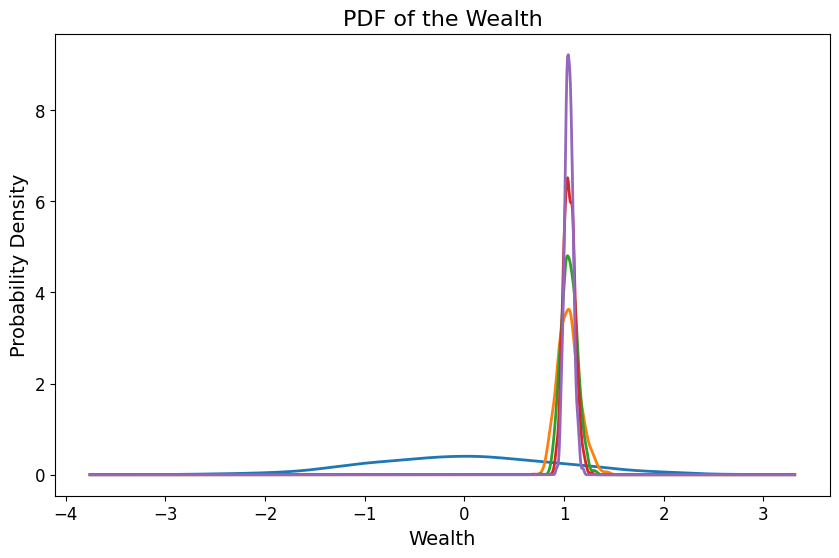

In [15]:
print("x_values shape:", x_values.shape)
print("kde_gl(x_values) shape:", kde_gl(x_values).shape)

# Plot the PDF of the wealth for Monte Carlo method
plt.figure(figsize=(10, 6))
plt.plot(x_values, kde_mc(x_values), linewidth=2, label='Monte Carlo')
plt.xlabel('Wealth', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('PDF of the Wealth', fontsize=16)
#plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot the PDF of the wealth for Gauss-Laguerre quadrature rule
mu = 0.1
sigma = 0.2
for depth in quadrature_depths:
    print(f"Calculating for depth: {depth}")
    nodes_gl, weights_gl = np.polynomial.legendre.leggauss(depth)
    nodes_gl = (nodes_gl + 1) / 2
    weights_gl /= 2

    wealths_gl[depth] = np.zeros_like(x_values)
    print(f"Initial wealths_gl[{depth}]:", wealths_gl[depth])

    for i, t in enumerate(nodes_gl):
        print(f"Processing node {i}: {t}")
        returns_t = np.exp((mu - 0.5 * sigma**2) * t + sigma * np.sqrt(t) * np.random.randn(x_values.shape[0]))
        wealths_gl[depth] += weights_gl[i] * returns_t

    print(f"Final wealths_gl[{depth}]:", wealths_gl[depth])
    print(f"Number of NaNs in wealths_gl[{depth}]:", np.isnan(wealths_gl[depth]).sum())
    print(f"Number of infs in wealths_gl[{depth}]:", np.isinf(wealths_gl[depth]).sum())

    wealths_gl[depth] = np.nan_to_num(wealths_gl[depth], nan=0.0, posinf=0.0, neginf=0.0)

    kde_gl = RegularizedKDE(wealths_gl[depth])
    plt.plot(x_values, kde_gl(x_values), linewidth=2, label=f'Quad={depth}')
